# **Finetuning for Text Classification**

This notebook will focus on the fine-tuning of a pre-trained model to carry out specific tasks, such as text-classification. The alternative i.e. instruction-finetuning will be covered in the next notebook.

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",  # Plotting library
        "numpy",       # PyTorch & TensorFlow dependency
        "tiktoken",    # Tokenizer
        "torch",       # Deep learning library
        "tensorflow",  # For OpenAI's pretrained weights
        "pandas"       # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.2.5
tiktoken version: 0.9.0
torch version: 2.7.0
tensorflow version: 2.19.0
pandas version: 2.2.3


## **The Task: Classification of Spam Emails**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

Here, we will be operating with a specific number of class labels i.e. "spam" and "not spam".

## **1. Preparation of the Dataset**

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "data/sms_spam_collection.zip"
extracted_path = "data/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

data/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
# Distributions
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

To make the task of training the LLM faster (solely for demonstration purposes), we will subsample the dataset so that it contains 747 instances from each class. Thereby making the dataset "balanced".

In [5]:
def create_balanced_dataset(df):
    # Count of spam instances
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Random sampling of "ham instances" to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=42)
    
    # Combine ham "subset" with "spam"
    bal_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    
    return bal_df

balanced_df = create_balanced_dataset(df)
balanced_df["Label"].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [6]:
# One-Hot Encode the string class labels "ham" and "spam"
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df 

,Label,Text
3714,0,If i not meeting ü all rite then i'll go home ...
1311,0,"I.ll always be there, even if its just in spir..."
548,0,"Sorry that took so long, omw now"
1324,0,I thk 50 shd be ok he said plus minus 10.. Did...
3184,0,Dunno i juz askin cos i got a card got 20% off...
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [7]:
# Function to randomly divide the dataset into training, validation and test subsets
def random_split(df, train_frac, valid_frac):
    # Shuffle the df
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Calculate split indices
    train_end = int(len(df) * train_frac)
    valid_end = train_end + int(len(df) * valid_frac)
    
    # Split the dataframe
    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]
    
    return train_df, valid_df, test_df

# Test size is 0.2
train_df, valid_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("data/sms_spam_collection/train.csv", index=None)
valid_df.to_csv("data/sms_spam_collection/valid.csv", index=None)
test_df.to_csv("data/sms_spam_collection/test.csv", index=None)

## **2. Creating the DataLoaders**

- Text messages have variable lengths, and they must either be truncated to the length of the shortest message in the dataset / batch or padded to the length of the longest message in the dataset / batch.
- We will proceed with padding while making use of the `<|endoftext|>` padding token.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/pad-input-sequences.webp?123" width=640px>

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [9]:
# Identify the longest sequence in the training dataset and add the padding token to others to match sequence length
import torch
from torch.utils.data import Dataset

PATH = "data/sms_spam_collection/"

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
        
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
            
        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
        
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        #for encoded_text in self.encoded_texts:
        #    encoded_length = len(encoded_text)
        #    if encoded_length > max_length:
        #        max_length = encoded_length
        #return max_length
        # More Pythonic version
        return max(len(encoded_text) for encoded_text in self.encoded_texts)

In [10]:
train_dataset = SpamDataset(
    csv_file=PATH + "/train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length) # Expect variation due to differences in seed values

109


In [11]:
# Padding the validation and test set
val_dataset = SpamDataset(
    csv_file=PATH+"valid.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file=PATH+"test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [12]:
# Prep data loaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(42)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [13]:
# Verification step
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 109])
Label batch dimensions torch.Size([8])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## **3. Initializing Model With Pretrained Weights**

In [15]:
MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [16]:
from utils.components import GPTModel
from utils.gpt_generate import load_weights_into_gpt

model_size = MODEL.split(" ")[-1].lstrip("(").rstrip(")")

model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load("gpt2/gpt2-medium-355M.pth", weights_only=True))
model.eval();

2025-07-30 16:10:25.036245: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 16:10:25.042919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753873825.051253   31720 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753873825.053716   31720 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753873825.060245   31720 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [17]:
from utils.components import generate_text_simple
from utils.gpt_generate import text_to_token_ids, token_ids_to_text


INPUT_PROMPT = "Open ended questions are"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(INPUT_PROMPT, tokenizer),
    max_new_tokens=20,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Open ended questions are not allowed.

Please note that the questions are not meant to be a substitute for a full


In [18]:
# Testing if gpt2-medium can already classify spam messages
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'


The model is decent at regurgitation, but fails at following instructions. This is a result of it begin pre-trained and not instruction fine-tuned.

## **4. Adding a Classification Head** 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/lm-head.webp" width=640px>

In [19]:
# Print the model architecture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

- We will now replace and finetune the output layer.
- The first step is to freeze the model.

In [20]:
for param in model.parameters():
    param.requires_grad = False

- The next step is to replace the `model.out_head` layer (output layer which maps to 50,257 dims) with a binary classification layer.
- Here `BASE_CONFIG["emb_dim"]` will retain the original size `1024`, based on `GPT2-Medium (355M)`.

In [21]:
torch.manual_seed(42)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [22]:
# Verifying changes
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [23]:
# The final Linear Output Layer (refer to architecture) and the Final Norm Layer are 
# made trainable
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
    
for param in model.final_norm.parameters():
    param.requires_grad = True

In [24]:
# By running previous text generation code blocks, we can note the change in the final outputs
inputs = tokenizer.encode("Is there a need")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Input dimensions:", inputs.shape) # where shape: (batch_size, num_tokens)

Inputs: tensor([[3792,  612,  257,  761]])
Input dimensions: torch.Size([1, 4])


In [25]:
# The difference compared to earlier notebooks is 2 dims compared to the original 50,257
with torch.no_grad():
    outputs = model(inputs)
    
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[ 3.9792, -4.1800],
         [ 5.5737, -5.2473],
         [ 5.0113, -5.2301],
         [-0.0092,  2.7158]]])
Outputs dimensions: torch.Size([1, 4, 2])


- Based on causal attention masking, current tokens only attend to the _current and previous_ token positions.
- This implies that the last token being processed by the attention mechanism contains the most amount of information compared to all other tokens. That is why we will focus on the last token for finetuning.

In [26]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-0.0092,  2.7158]])


## **5. Calculating the Classification Loss and Accuracy**

In [27]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-0.0092,  2.7158]])


In [28]:
# Converting the output (logits) into probability scores and getting the index position of the highest prob value
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [29]:
# Softmax can be treated as optional
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [30]:
# Applying the concept to calculate classification accuracy i.e. compute the %age of correct predictions in a given dataset
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :] # logits og last output token
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [31]:
# Testing classification accuracies for training datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(42)

train_acc = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_acc = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_acc = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_acc*100:.2f}%")
print(f"Validation accuracy: {val_acc*100:.2f}%")
print(f"Test accuracy: {test_acc*100:.2f}%")

Training accuracy: 50.00%
Validation accuracy: 46.25%
Test accuracy: 41.25%


In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [33]:
# Copying the calc_loss_loader from NB 4
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [34]:
# Use the calc_loss_loader to compute the initial training validation and test set losses before training
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.162
Validation loss: 2.045
Test loss: 2.545


## **6. Finetuning The Model on Supervised Data**

In [35]:
# This modified version of train_model_simple() tracks the number of training examples instead of tokens seen
# and calculates the accuracy after each epoch instead of printing a sample text after each epoch.abs
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0] # Tracks examples instead of tokens
            global_step += 1
            
            # Additional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [36]:
# evaluate_model() is based on train_classifier_simple()
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [37]:
import time

start_time = time.time()

torch.manual_seed(42)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
exec_time = (end_time - start_time) / 60
print(f"Training completed in {exec_time:.2f} minutes.")

Epoch 1 (Step 000000): Train loss 1.660, Val loss 1.913
Epoch 1 (Step 000050): Train loss 0.643, Val loss 0.611
Epoch 1 (Step 000100): Train loss 0.412, Val loss 0.462
Training accuracy: 85.00% | Validation accuracy: 92.50%
Epoch 2 (Step 000150): Train loss 0.367, Val loss 0.409
Epoch 2 (Step 000200): Train loss 0.432, Val loss 0.390
Epoch 2 (Step 000250): Train loss 0.461, Val loss 0.366
Training accuracy: 82.50% | Validation accuracy: 87.50%
Epoch 3 (Step 000300): Train loss 0.254, Val loss 0.333
Epoch 3 (Step 000350): Train loss 0.117, Val loss 0.289
Training accuracy: 92.50% | Validation accuracy: 90.00%
Epoch 4 (Step 000400): Train loss 0.159, Val loss 0.138
Epoch 4 (Step 000450): Train loss 0.083, Val loss 0.277
Epoch 4 (Step 000500): Train loss 0.082, Val loss 0.164
Training accuracy: 95.00% | Validation accuracy: 95.00%
Epoch 5 (Step 000550): Train loss 0.135, Val loss 0.073
Epoch 5 (Step 000600): Train loss 0.169, Val loss 0.067
Training accuracy: 92.50% | Validation accuracy:

In [41]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show();

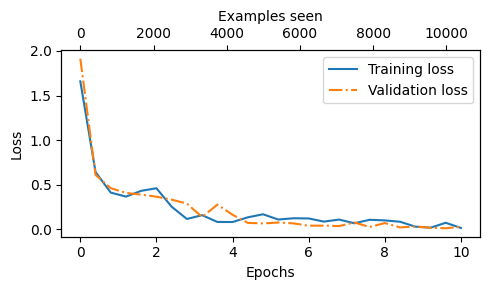

In [42]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

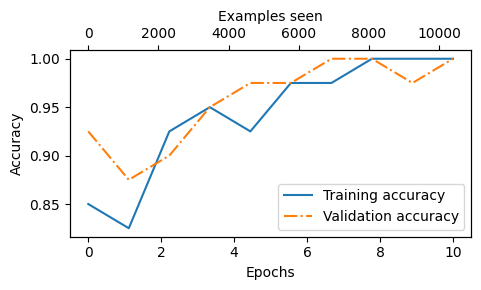

In [43]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [44]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.13%
Validation accuracy: 99.33%
Test accuracy: 96.00%


## **7. LLM as a Classifier** 

In [46]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    
    # Prep inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0] # Using shape[1] truncates the inputs to emb_dim
    
    # Truncate sequences if they are too long
    input_ids = input_ids[:min(max_length, supported_context_length)]
    assert max_length is not None, (
        "max_length must be specified. If you want to use the full model context, "
        "pass max_length=model.pos_emb.weight.shape[0]."
    )
    assert max_length <= supported_context_length, (
        f"max_length ({max_length}) exceeds model's supported context length ({supported_context_length})."
    )
    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dim
    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"

In [47]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [50]:
text_2 = (
    "Hey, hope you had a relaxing weekend."
    " I am attaching some files which need your assessments."
    " A number of irregularities have been highlighted."
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [51]:
torch.save(model.state_dict(), "models/review_classifier_gpt2_medium.pth")